# IMPORT LIBRARY

In [220]:
import os
import random
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import f1_score

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.random import set_seed

from lstm import LSTM_from_Scratch, DenseLayer, EmbeddingLayer, LSTMLayer 

In [128]:
set_seed(42)
np.random.seed(42)
random.seed(42)

In [129]:
sns.set_theme(style="whitegrid", palette="pastel")

# IMPORT DATASETS

In [130]:
df_train = pd.read_csv('https://drive.google.com/uc?id=1qOIeJsdYDd40AHEWJsvAvvrziYSb1Dfk')
df_val = pd.read_csv('https://drive.google.com/uc?id=1qMkR0WU_O_moKFRDkVdfOqaiau636nWY')
df_test = pd.read_csv('https://drive.google.com/uc?id=1qM2vuX3_cuqdw_URoxpUnwE1Tk_SJV97')

# EDA

In [131]:
df_train.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive


In [132]:
df_val.head()

,id,text,label
0,237,Jika ada pertanyaan lebih lanjut yang ingin ka...,neutral
1,101,Rasanya sih kok harga kaki lima dan rasanya ya...,negative
2,556,"Minimal cek pesan saya, ada problem yang rumit...",neutral
3,474,Dulu restoran ini merupakan favorit saya karen...,negative
4,42,Merupakan resto vintage dengan harga yang cuku...,positive


In [133]:
df_test.head()

,id,text,label
0,411,"Dekat dengan hotel saya menginap, hanya ditemp...",positive
1,729,"Iya benar, dia sedang jaga warung.",neutral
2,373,Kangkungnya lumayan tapi kepiting saus padangn...,negative
3,262,Bertempat di braga city walk yang satu gedung ...,positive
4,177,Gianyar terima bantuan sosial 2018 sebesar rp ...,neutral


In [134]:
print(f'df_train shape: {df_train.shape}')
print(f'df_val shape: {df_val.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (500, 3)
df_val shape: (100, 3)
df_test shape: (400, 3)


# PREPROCESS

In [135]:
class TextPreprocessor:
    def __init__(self,
                 text_col='text',
                 label_col='label',
                 max_words=10000,
                 max_len=100,
                 embedding_dim=100,
                 embedding_path='glove.6B.100d.txt'):
        self.text_col = text_col
        self.label_col = label_col
        self.max_words = max_words
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.embedding_path = embedding_path

        self.tokenizer = None
        self.embedding_matrix = None
        self.label_map = {'neutral': 1, 'positive': 2, 'negative': 0}
        self.fitted = False

    def fit(self, df):
        self.tokenizer = Tokenizer(num_words=self.max_words, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(df[self.text_col].astype(str))

        if self.embedding_path:
            embeddings_index = {}
            with open(self.embedding_path, encoding='utf-8') as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
            word_index = self.tokenizer.word_index
            num_words = min(self.max_words, len(word_index) + 1)
            self.embedding_matrix = np.zeros((num_words, self.embedding_dim))
            for word, i in word_index.items():
                if i >= self.max_words:
                    continue
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    self.embedding_matrix[i] = embedding_vector
        self.fitted = True
        return self

    def transform(self, df):
        if not self.fitted:
            raise ValueError("TextPreprocessor must be fitted before calling transform.")

        y = df[self.label_col].map(self.label_map).values if self.label_col in df else None
        sequences = self.tokenizer.texts_to_sequences(df[self.text_col].astype(str))
        X = pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')
        return X, y

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

    def get_tokenizer(self):
        return self.tokenizer

    def get_embedding_matrix(self):
        return self.embedding_matrix

In [136]:
preprocessor = TextPreprocessor(text_col='text', label_col='label')
df_train_preprocessed = preprocessor.fit_transform(df_train)
df_val_preprocessed = preprocessor.transform(df_val)
df_test_preprocessed = preprocessor.transform(df_test)

In [137]:
df_train_preprocessed

(array([[1152,  736,  737, ...,    0,    0,    0],
        [ 295,  295,    2, ...,    0,    0,    0],
        [ 359,  151,  443, ...,    0,    0,    0],
        ...,
        [ 117,    5, 2780, ...,    0,    0,    0],
        [2786,   54,  214, ...,    0,    0,    0],
        [  91,   91,    3, ...,    0,    0,    0]]),
 array([1, 2, 1, 2, 2, 1, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 1, 0, 1, 2,
        2, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2,
        0, 0, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 1, 2, 1, 2,
        1, 1, 0, 1, 0, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1,
        2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 1, 2, 0,
        1, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 1, 0,
        2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 2, 0, 0, 1,
        1, 1, 0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 0, 1, 2, 0, 2, 0, 0, 2, 0, 1,
        2, 2, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 2, 0, 2, 0, 2, 0, 2, 2,
        2, 0,

# MODELLING

## IMPORT LIBRARIES

## DEFINE FUNCTIONS

In [138]:
epsilon = 1e-7
n_samples = len(df_val)

max_loss_per_sample = -np.log(epsilon)
max_total_loss = n_samples * max_loss_per_sample

print(f"Max possible loss per sample: {max_loss_per_sample:.2f}")
print(f"Max possible loss for {n_samples} samples: {max_total_loss:.2f}")


Max possible loss per sample: 16.12
Max possible loss for 100 samples: 1611.81


In [139]:
def plot_training_history(history, acc_key='accuracy', val_acc_key='val_accuracy',
                         loss_key='loss', val_loss_key='val_loss', title='Training History'):
    sns.set(style='whitegrid')
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, len(history.history[acc_key]) + 1),
                 y=history.history[acc_key], label='Train Accuracy', marker='o')
    sns.lineplot(x=range(1, len(history.history[val_acc_key]) + 1),
                 y=history.history[val_acc_key], label='Validation Accuracy', marker='s')
    plt.title('Model Accuracy', fontsize=14, weight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()

    # Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, len(history.history[loss_key]) + 1),
                 y=history.history[loss_key], label='Train Loss', marker='o')
    sns.lineplot(x=range(1, len(history.history[val_loss_key]) + 1),
                 y=history.history[val_loss_key], label='Validation Loss', marker='s')
    plt.title('Model Loss', fontsize=14, weight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.ylim(0, 1.25)
    plt.legend()
    plt.tight_layout()

    plt.suptitle(title, fontsize=16, weight='bold', y=1.03)
    plt.show()


In [204]:
def plot_multiple_training_histories(histories, model_names=None, val_acc_key='val_accuracy', val_loss_key='val_loss', title='Validation Performance Comparison'):
    
    sns.set(style='whitegrid')
    plt.figure(figsize=(15, 6))

    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(histories))]

    base_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                   'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
                   'tab:olive', 'tab:cyan']

    # Validation Accuracy
    plt.subplot(1, 2, 1)
    for idx, (hist, name) in enumerate(zip(histories, model_names)):
        color = base_colors[idx % len(base_colors)]
        if hasattr(hist, "history"):
            h = hist.history
        else:
            h = hist
        if val_acc_key in h:
            plt.plot(range(1, len(h[val_acc_key]) + 1), h[val_acc_key], 
                     marker='o', linestyle='-', label=f'{name}', color=color)
    plt.title('Validation Accuracy', fontsize=14, weight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()

    # Validation Loss
    plt.subplot(1, 2, 2)
    for idx, (hist, name) in enumerate(zip(histories, model_names)):
        color = base_colors[idx % len(base_colors)]
        if hasattr(hist, "history"):
            h = hist.history
        else:
            h = hist
        if val_loss_key in h:
            plt.plot(range(1, len(h[val_loss_key]) + 1), h[val_loss_key], 
                     marker='s', linestyle='-', label=f'{name}', color=color)
    plt.title('Validation Loss', fontsize=14, weight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.ylim(0, 2.5)
    plt.legend()
    plt.tight_layout()

    plt.suptitle(title, fontsize=16, weight='bold', y=1.04)
    plt.show()


## DEFINE GLOBAL VARIABLE

In [141]:
max_words = preprocessor.max_words
max_len = preprocessor.max_len
embedding_dim = preprocessor.embedding_dim
embedding_matrix = preprocessor.get_embedding_matrix()
actual_vocab_size = len(preprocessor.get_tokenizer().word_index) + 1
EPOCH = 50

In [142]:
X_train, y_train = df_train_preprocessed
X_val, y_val = df_val_preprocessed

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## COMPARING

### Layers

#### 2 Layers LSTM

In [143]:
model_lstm_2_layers = Sequential()

model_lstm_2_layers.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_2_layers.add(SpatialDropout1D(0.2))
model_lstm_2_layers.add(LSTM(64, return_sequences=True))
model_lstm_2_layers.add(LSTM(64))
model_lstm_2_layers.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [144]:
model_lstm_2_layers.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history_lstm_2_layers = model_lstm_2_layers.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
history_lstm_2_layers = model_lstm_2_layers.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.3570 - loss: 1.0948 - val_accuracy: 0.3800 - val_loss: 1.0815
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3981 - loss: 1.0756 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3889 - loss: 1.0685 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3889 - loss: 1.0723 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3889 - loss: 1.0710 - val_accuracy: 0.3800 - val_loss: 1.0772
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3905 - loss: 1.0670 - val_accuracy: 0.4800 - val_loss: 1.0553
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4432 - loss: 1.0480 - val_accuracy: 0.3700 - val_loss: 1.0769
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4095 - loss: 1.0741 - val_accuracy: 0.3800 - val_loss: 1.0837

In [145]:
model_lstm_2_layers.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_16            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_69 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,979 (1.93 MB)

 Trainable params: 75,459 (294.76 KB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 150,920 (589.54 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Validation Loss: 0.9991
Validation Accuracy: 0.6200
Validation Macro F1-score: 0.5895
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Test Loss: 0.8884
Test Accuracy: 0.6675
Test Macro F1-score: 0.6472


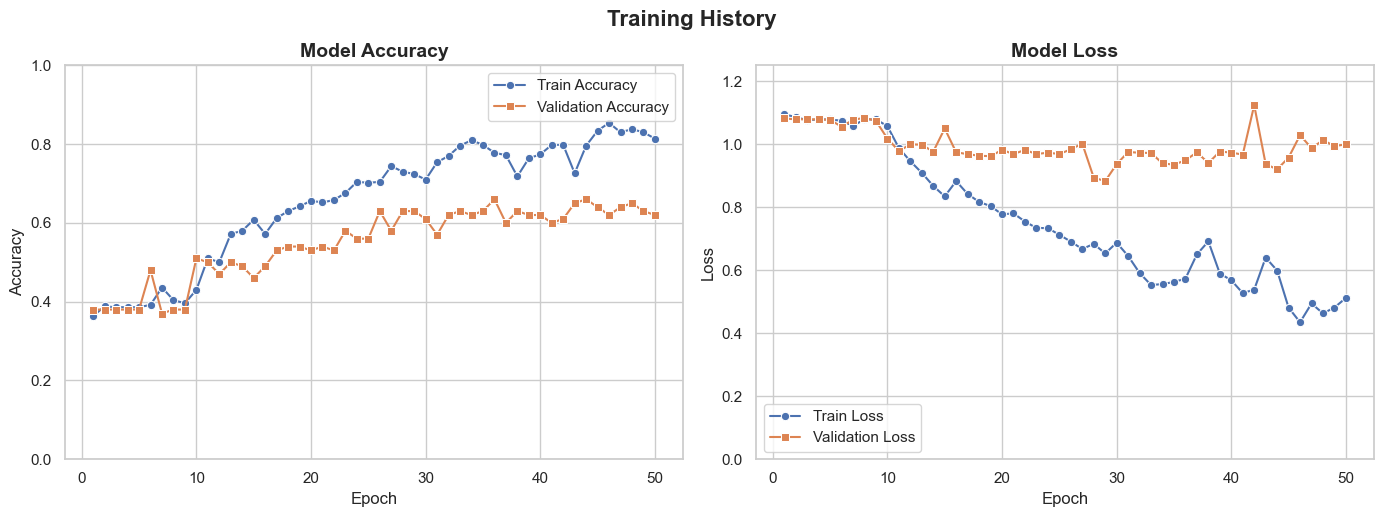

In [146]:
loss, accuracy = model_lstm_2_layers.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_2_layers.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_2_layers.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_2_layers.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [147]:
model_lstm_2_layers.save(f'models/lstm_model_2_layers.h5')

#### 4 Layers LSTM

In [148]:
model_lstm_4_layers = Sequential()

model_lstm_4_layers.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_4_layers.add(SpatialDropout1D(0.2))
model_lstm_4_layers.add(LSTM(64, return_sequences=True))
model_lstm_4_layers.add(LSTM(64, return_sequences=True))
model_lstm_4_layers.add(LSTM(64, return_sequences=True))
model_lstm_4_layers.add(LSTM(64))
model_lstm_4_layers.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [149]:
model_lstm_4_layers.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history_lstm_4_layers = model_lstm_4_layers.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
history_lstm_4_layers = model_lstm_4_layers.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.3078 - loss: 1.0931 - val_accuracy: 0.3800 - val_loss: 1.0767
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.3882 - loss: 1.0695 - val_accuracy: 0.3800 - val_loss: 1.0729
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.3972 - loss: 1.0547 - val_accuracy: 0.4700 - val_loss: 1.0315
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5031 - loss: 1.0121 - val_accuracy: 0.4500 - val_loss: 0.9878
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5152 - loss: 0.9522 - val_accuracy: 0.4500 - val_loss: 1.0018
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5502 - loss: 0.9178 - val_accuracy: 0.4800 - val_loss: 0.9760
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5610 - loss: 0.8752 - val_accuracy: 0.5000 - val_loss: 0.9915
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5869 - loss: 0.8537 - val_accuracy: 0.5100 - val_loss:

In [150]:
model_lstm_4_layers.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_17            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_70 (LSTM)                  │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,123 (2.69 MB)

 Trainable params: 141,507 (552.76 KB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 283,016 (1.08 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
Validation Loss: 1.0570
Validation Accuracy: 0.6200
Validation Macro F1-score: 0.6032
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Test Loss: 0.9433
Test Accuracy: 0.6450
Test Macro F1-score: 0.6293


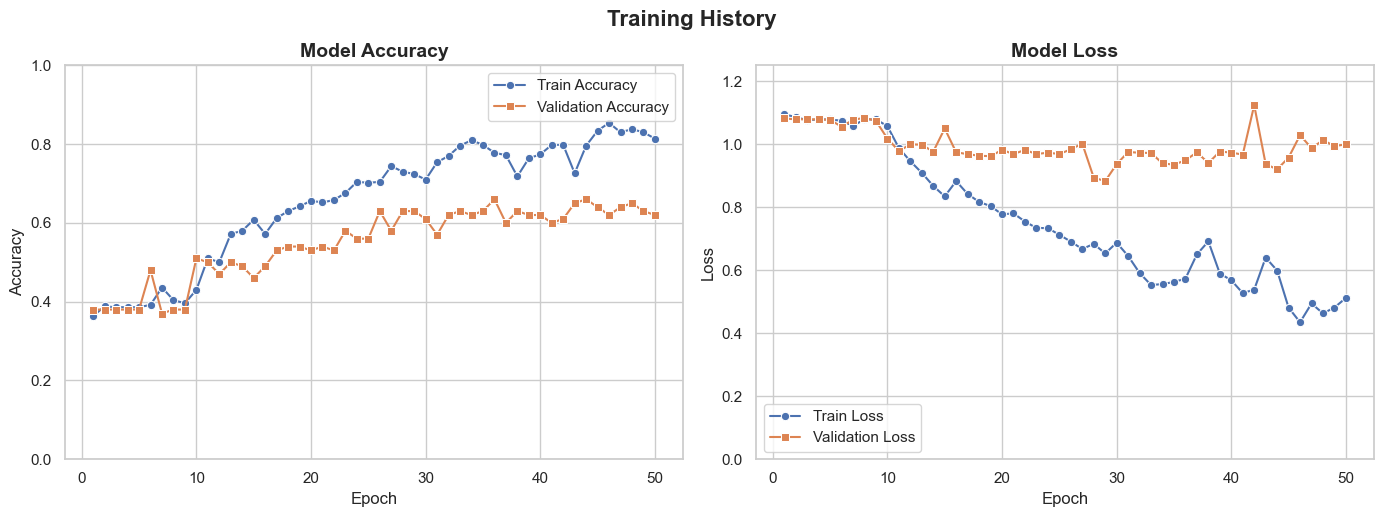

In [151]:
loss, accuracy = model_lstm_4_layers.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_4_layers.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_4_layers.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_4_layers.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [152]:
model_lstm_4_layers.save(f'models/lstm_model_4_layers.h5')

#### 8 Layers LSTM

In [153]:
model_lstm_8_layers = Sequential()

model_lstm_8_layers.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_8_layers.add(SpatialDropout1D(0.2))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64))
model_lstm_8_layers.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [154]:
model_lstm_8_layers.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history_lstm_8_layers = model_lstm_8_layers.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
history_lstm_8_layers = model_lstm_8_layers.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 404ms/step - accuracy: 0.3966 - loss: 1.0935 - val_accuracy: 0.5000 - val_loss: 1.0495
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.4917 - loss: 1.0265 - val_accuracy: 0.4700 - val_loss: 0.9657
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.5161 - loss: 0.9428 - val_accuracy: 0.4800 - val_loss: 0.9918
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.5623 - loss: 0.8831 - val_accuracy: 0.4900 - val_loss: 0.9686
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.5949 - loss: 0.8531 - val_accuracy: 0.5200 - val_loss: 0.9487
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.6134 - loss: 0.8299 - val_accuracy: 0.5100 - val_loss: 1.0034
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.5855 - loss: 0.8494 - val_accuracy: 0.5100 - val_loss: 1.0152
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.6159 - loss: 0.8247 - val_accuracy: 0.5500 - val_loss

In [155]:
model_lstm_8_layers.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_18            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_78 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,100,411 (4.20 MB)

 Trainable params: 273,603 (1.04 MB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 547,208 (2.09 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step
Validation Loss: 1.1644
Validation Accuracy: 0.5600
Validation Macro F1-score: 0.5364
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
Test Loss: 0.9797
Test Accuracy: 0.6675
Test Macro F1-score: 0.6552


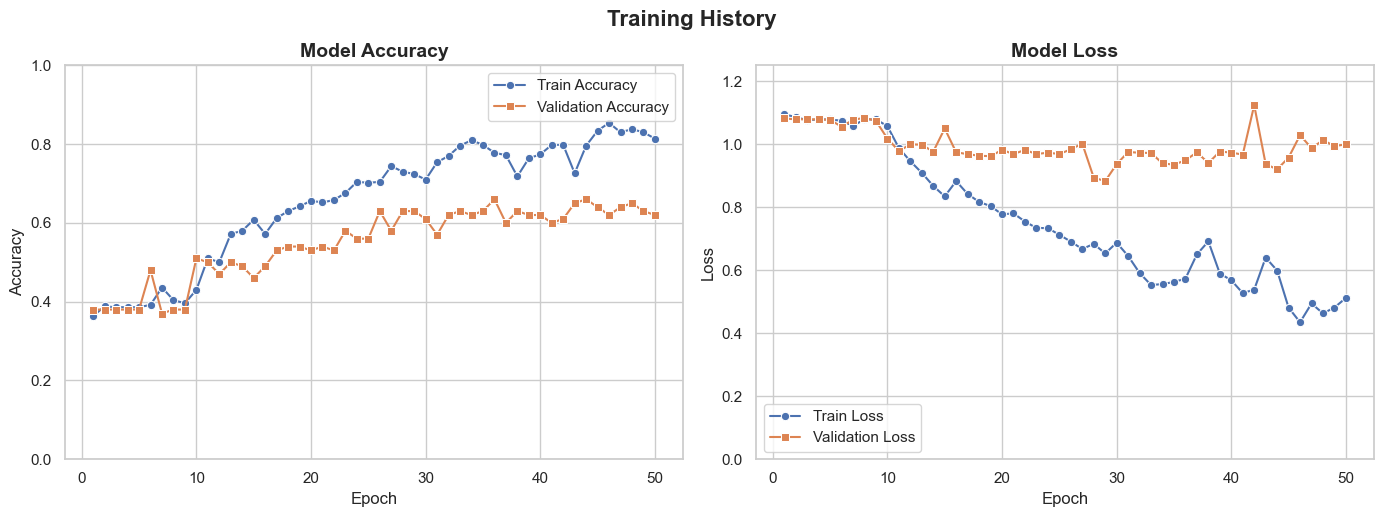

In [156]:
loss, accuracy = model_lstm_8_layers.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_8_layers.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_8_layers.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_8_layers.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [157]:
model_lstm_8_layers.save(f'models/lstm_model_8_layers.h5')

#### Compare

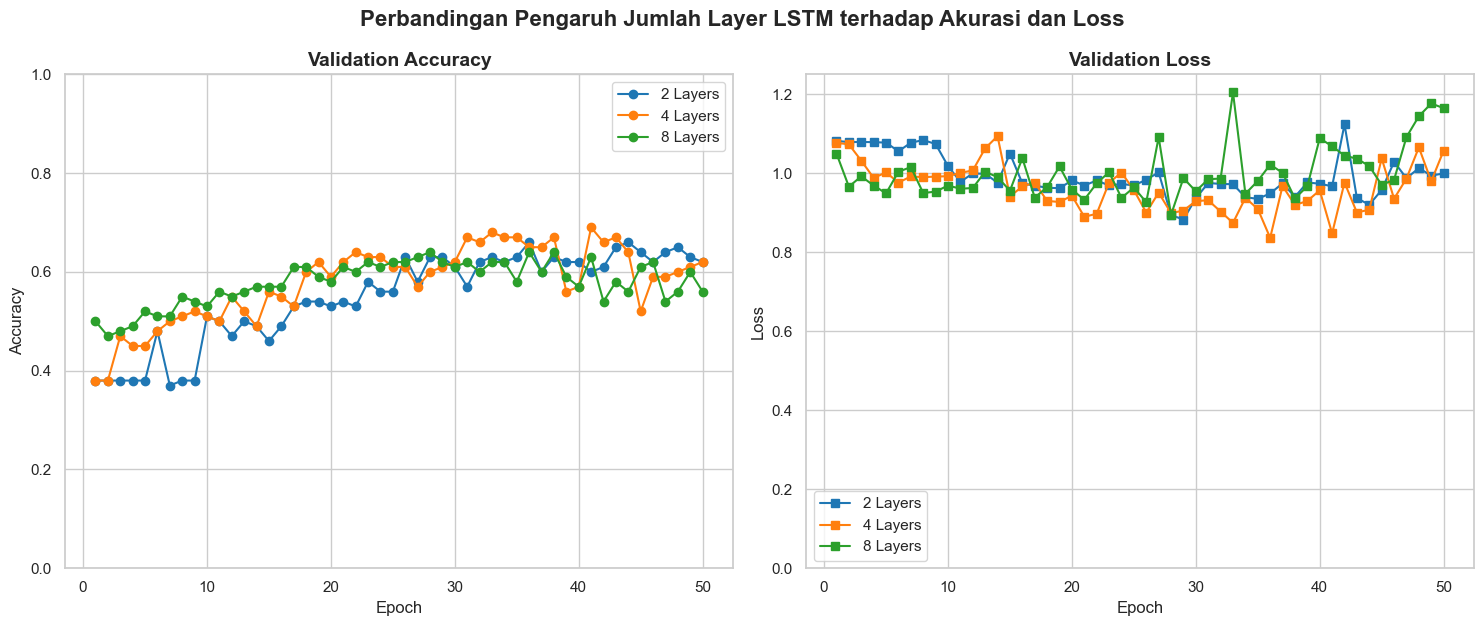

In [158]:
plot_multiple_training_histories(
    histories=[history_lstm_2_layers, history_lstm_4_layers, history_lstm_8_layers],
    model_names=["2 Layers", "4 Layers", "8 Layers"],
    title="Perbandingan Pengaruh Jumlah Layer LSTM terhadap Akurasi dan Loss"
)

### Cells

#### 16 Cells LSTM

In [159]:
model_lstm_16_cells = Sequential()

model_lstm_16_cells.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_16_cells.add(SpatialDropout1D(0.2))
model_lstm_16_cells.add(LSTM(16, return_sequences=True))
model_lstm_16_cells.add(LSTM(16, return_sequences=True))
model_lstm_16_cells.add(LSTM(16, return_sequences=True))
model_lstm_16_cells.add(LSTM(16))
model_lstm_16_cells.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [160]:
model_lstm_16_cells.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history_lstm_16_cells = model_lstm_16_cells.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
history_lstm_16_cells = model_lstm_16_cells.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.3570 - loss: 1.0962 - val_accuracy: 0.4100 - val_loss: 1.0889
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.3988 - loss: 1.0840 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.3889 - loss: 1.0713 - val_accuracy: 0.3800 - val_loss: 1.0770
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.4044 - loss: 1.0651 - val_accuracy: 0.3800 - val_loss: 1.0743
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.3917 - loss: 1.0620 - val_accuracy: 0.3800 - val_loss: 1.0652
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3917 - loss: 1.0450 - val_accuracy: 0.4300 - val_loss: 1.0347
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.4755 - loss: 1.0047 - val_accuracy: 0.5200 - val_loss: 1.0062
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.5311 - loss: 0.9551 - val_accuracy: 0.4800 - val_loss:

In [161]:
model_lstm_16_cells.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_19            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_82 (LSTM)                  │ (None, 100, 16)        │         7,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 100, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_84 (LSTM)                  │ (None, 100, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,227 (1.23 MB)

 Trainable params: 13,875 (54.20 KB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 27,752 (108.41 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Validation Loss: 1.0315
Validation Accuracy: 0.5800
Validation Macro F1-score: 0.5591
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Test Loss: 0.9375
Test Accuracy: 0.6450
Test Macro F1-score: 0.6317


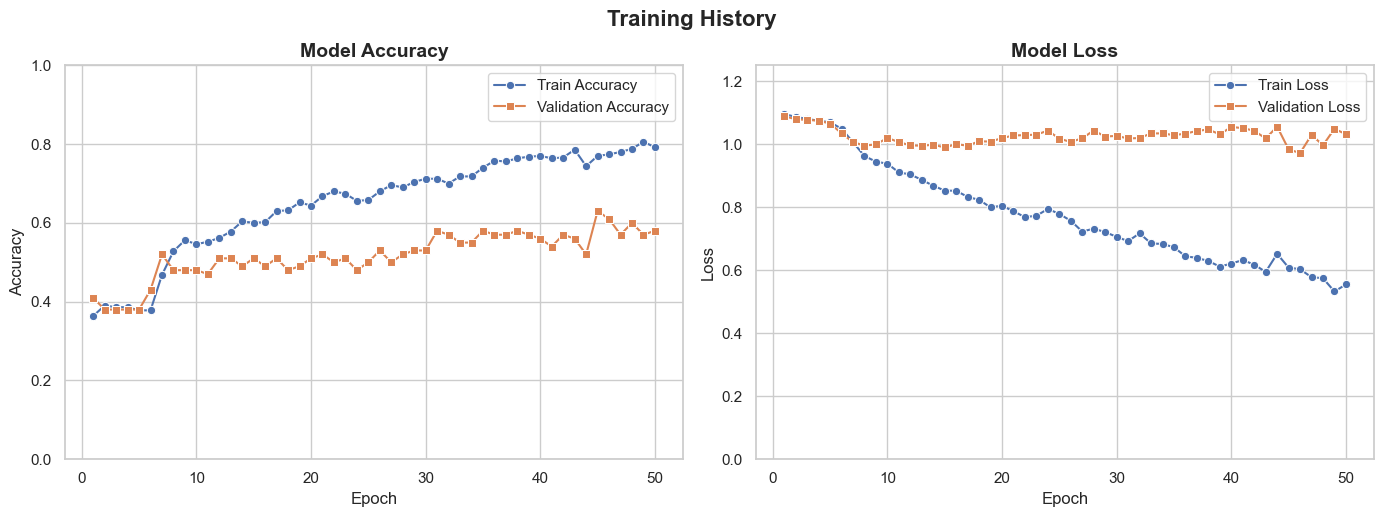

In [186]:
loss, accuracy = model_lstm_16_cells.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_16_cells.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_16_cells.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_16_cells.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_16_cells)

In [187]:
model_lstm_16_cells.save(f'models/lstm_model_16_cells.h5')

#### 64 Cells LSTM

In [164]:
model_lstm_64_cells = Sequential()

model_lstm_64_cells.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_64_cells.add(SpatialDropout1D(0.2))
model_lstm_64_cells.add(LSTM(64, return_sequences=True))
model_lstm_64_cells.add(LSTM(64, return_sequences=True))
model_lstm_64_cells.add(LSTM(64, return_sequences=True))
model_lstm_64_cells.add(LSTM(64))
model_lstm_64_cells.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [165]:
model_lstm_64_cells.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history_lstm_64_cells = model_lstm_64_cells.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
history_lstm_64_cells = model_lstm_64_cells.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.3681 - loss: 1.0932 - val_accuracy: 0.4200 - val_loss: 1.0738
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.4398 - loss: 1.0605 - val_accuracy: 0.5100 - val_loss: 1.0344
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.5056 - loss: 1.0302 - val_accuracy: 0.5200 - val_loss: 1.0115
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5284 - loss: 0.9841 - val_accuracy: 0.4200 - val_loss: 1.0007
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.4998 - loss: 0.9581 - val_accuracy: 0.4800 - val_loss: 0.9994
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.5875 - loss: 0.8867 - val_accuracy: 0.4500 - val_loss: 1.0037
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5910 - loss: 0.8659 - val_accuracy: 0.5300 - val_loss: 0.9800
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.5879 - loss: 0.8517 - val_accuracy: 0.5000 - val_loss:

In [166]:
model_lstm_64_cells.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_20            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_86 (LSTM)                  │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_87 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_88 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,123 (2.69 MB)

 Trainable params: 141,507 (552.76 KB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 283,016 (1.08 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Validation Loss: 1.1336
Validation Accuracy: 0.5900
Validation Macro F1-score: 0.5663
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Test Loss: 0.9952
Test Accuracy: 0.6650
Test Macro F1-score: 0.6501


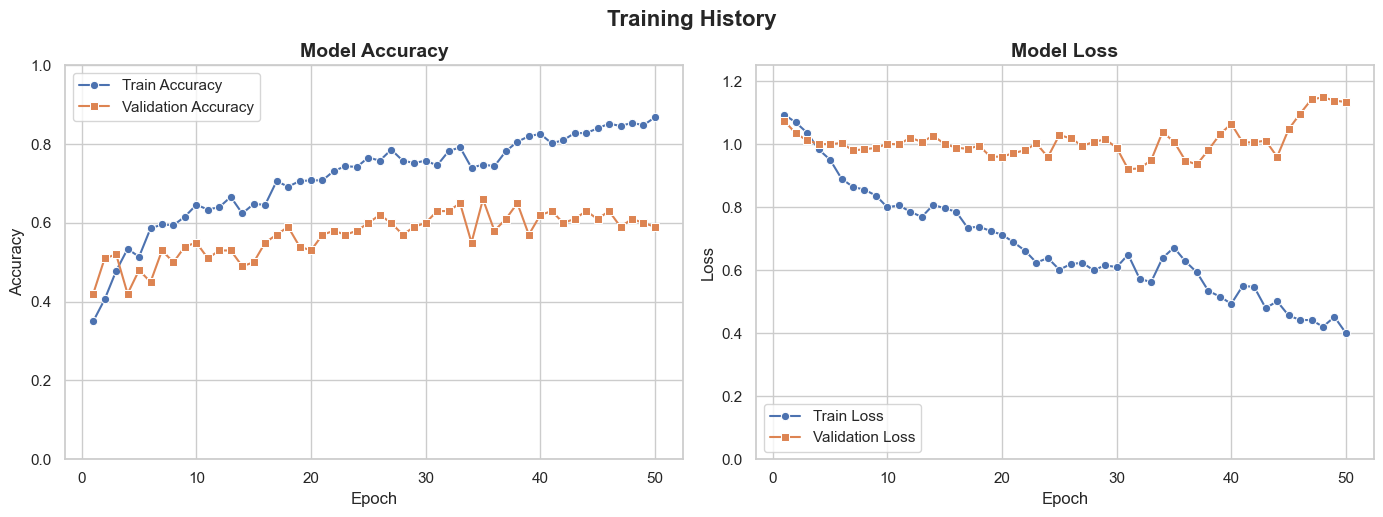

In [188]:
loss, accuracy = model_lstm_64_cells.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_64_cells.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_64_cells.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_64_cells.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_64_cells)

In [189]:
model_lstm_64_cells.save(f'models/lstm_model_64_cells.h5')

#### 128 Cells LSTM

In [169]:
model_lstm_128_cells = Sequential()

model_lstm_128_cells.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_128_cells.add(SpatialDropout1D(0.2))
model_lstm_128_cells.add(LSTM(128, return_sequences=True))
model_lstm_128_cells.add(LSTM(128, return_sequences=True))
model_lstm_128_cells.add(LSTM(128, return_sequences=True))
model_lstm_128_cells.add(LSTM(128))
model_lstm_128_cells.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [170]:
model_lstm_128_cells.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history_lstm_128_cells = model_lstm_128_cells.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
history_lstm_128_cells = model_lstm_128_cells.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 688ms/step - accuracy: 0.3660 - loss: 1.0898 - val_accuracy: 0.3900 - val_loss: 1.0660
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step - accuracy: 0.4689 - loss: 1.0403 - val_accuracy: 0.3300 - val_loss: 1.0617
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 557ms/step - accuracy: 0.3998 - loss: 1.0280 - val_accuracy: 0.4500 - val_loss: 0.9872
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 561ms/step - accuracy: 0.4710 - loss: 0.9751 - val_accuracy: 0.5100 - val_loss: 0.9800
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 557ms/step - accuracy: 0.5711 - loss: 0.8956 - val_accuracy: 0.4900 - val_loss: 0.9714
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 560ms/step - accuracy: 0.5886 - loss: 0.8651 - val_accuracy: 0.4900 - val_loss: 0.9654
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.5922 - loss: 0.8500 - val_accuracy: 0.4300 - val_loss: 1.0312
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step - accuracy: 0.5611 - loss: 0.8954 - val_accuracy: 0.5000 - val_loss:

In [171]:
model_lstm_128_cells.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_21            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_90 (LSTM)                  │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_93 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,816,763 (6.93 MB)

 Trainable params: 512,387 (1.95 MB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 1,024,776 (3.91 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Validation Loss: 1.0940
Validation Accuracy: 0.6500
Validation Macro F1-score: 0.6262
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
Test Loss: 0.9479
Test Accuracy: 0.6800
Test Macro F1-score: 0.6647


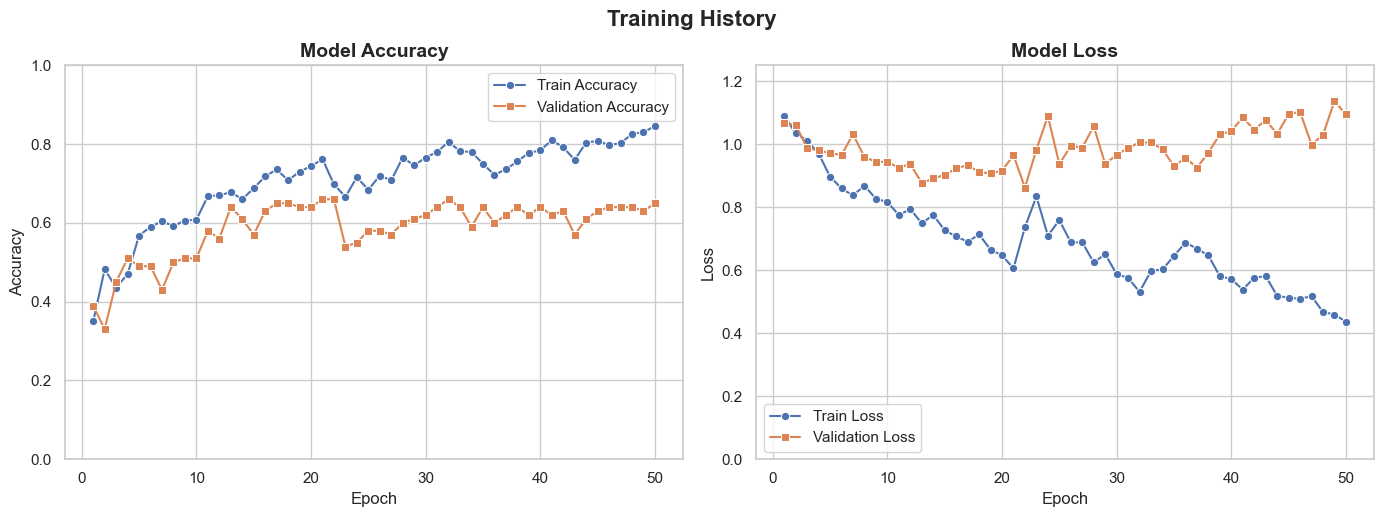

In [190]:
loss, accuracy = model_lstm_128_cells.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_128_cells.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_128_cells.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_128_cells.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_128_cells)

In [191]:
model_lstm_128_cells.save(f'models/lstm_model_128_cells.h5')

#### Compare

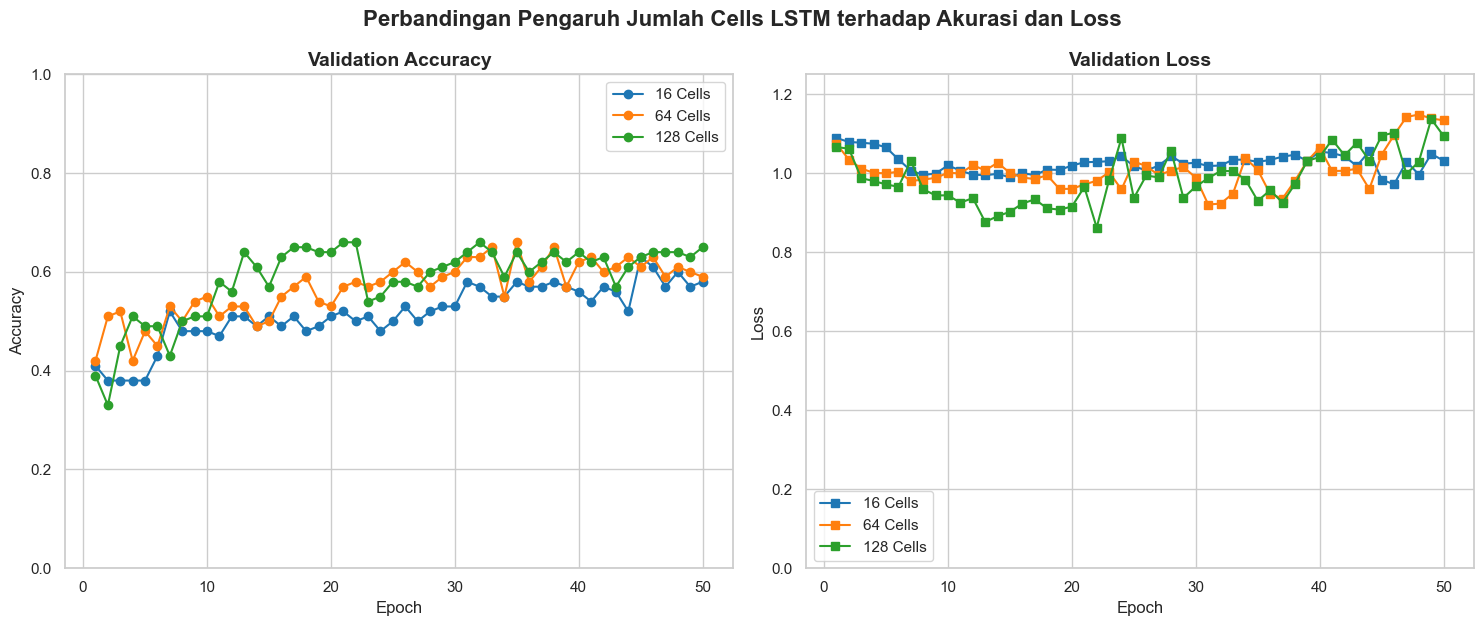

In [193]:
plot_multiple_training_histories(
    histories=[history_lstm_16_cells, history_lstm_64_cells, history_lstm_128_cells],
    model_names=["16 Cells", "64 Cells", "128 Cells"],
    title="Perbandingan Pengaruh Jumlah Cells LSTM terhadap Akurasi dan Loss"
)

### Type

#### Unidirectional

In [174]:
model_lstm_unidirectional = Sequential()
model_lstm_unidirectional.add(Embedding(input_dim=actual_vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
model_lstm_unidirectional.add(SpatialDropout1D(0.2))
model_lstm_unidirectional.add(LSTM(128, return_sequences=True))
model_lstm_unidirectional.add(LSTM(128, return_sequences=True))
model_lstm_unidirectional.add(LSTM(128, return_sequences=True))
model_lstm_unidirectional.add(LSTM(128))
model_lstm_unidirectional.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [175]:
model_lstm_unidirectional.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history_uni = model_lstm_unidirectional.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
history_uni = model_lstm_unidirectional.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 668ms/step - accuracy: 0.3462 - loss: 1.0922 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - accuracy: 0.4111 - loss: 1.0838 - val_accuracy: 0.5200 - val_loss: 1.0222
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.4568 - loss: 1.0521 - val_accuracy: 0.4900 - val_loss: 1.0860
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 585ms/step - accuracy: 0.4307 - loss: 1.0817 - val_accuracy: 0.3800 - val_loss: 1.0657
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.4094 - loss: 1.0408 - val_accuracy: 0.4700 - val_loss: 1.0084
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 593ms/step - accuracy: 0.4760 - loss: 1.0595 - val_accuracy: 0.3700 - val_loss: 1.0410
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 586ms/step - accuracy: 0.4656 - loss: 1.0246 - val_accuracy: 0.4300 - val_loss: 1.0230
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 588ms/step - accuracy: 0.4991 - loss: 0.9800 - val_accuracy: 0.4400 - val_loss:

In [176]:
model_lstm_unidirectional.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_22            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_94 (LSTM)                  │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_95 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_96 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_97 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,816,763 (6.93 MB)

 Trainable params: 512,387 (1.95 MB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 1,024,776 (3.91 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Validation Loss: 1.1536
Validation Accuracy: 0.6500
Validation Macro F1-score: 0.6258
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
Test Loss: 1.0627
Test Accuracy: 0.6650
Test Macro F1-score: 0.6493


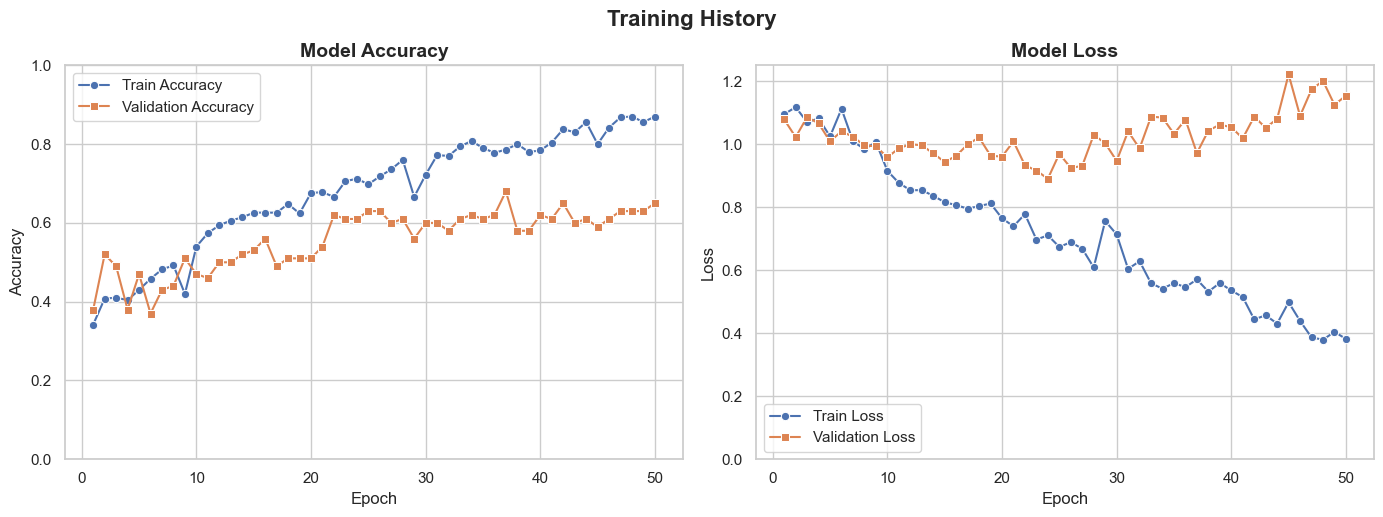

In [195]:
loss, accuracy = model_lstm_unidirectional.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_unidirectional.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_unidirectional.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_unidirectional.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_uni)

In [196]:
model_lstm_unidirectional.save(f'models/lstm_model_unidirectional.h5')

#### Bidirectional

In [180]:
model_lstm_bidirectional = Sequential()
model_lstm_bidirectional.add(Embedding(input_dim=actual_vocab_size,
                       output_dim=embedding_dim,
                       weights=[embedding_matrix],
                       input_length=max_len,
                       trainable=False))
model_lstm_bidirectional.add(SpatialDropout1D(0.2))
model_lstm_bidirectional.add(Bidirectional(LSTM(128, return_sequences=True)))
model_lstm_bidirectional.add(Bidirectional(LSTM(128, return_sequences=True)))
model_lstm_bidirectional.add(Bidirectional(LSTM(128, return_sequences=True)))
model_lstm_bidirectional.add(Bidirectional(LSTM(128)))
model_lstm_bidirectional.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [181]:
model_lstm_bidirectional.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history_bi = model_lstm_bidirectional.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
history_bi = model_lstm_bidirectional.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4386 - loss: 1.0387 - val_accuracy: 0.4600 - val_loss: 0.9916
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5830 - loss: 0.8814 - val_accuracy: 0.5300 - val_loss: 0.9478
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6426 - loss: 0.7935 - val_accuracy: 0.6200 - val_loss: 0.9146
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7013 - loss: 0.7039 - val_accuracy: 0.6000 - val_loss: 0.9208
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7562 - loss: 0.6351 - val_accuracy: 0.6400 - val_loss: 0.8788
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7614 - loss: 0.6073 - val_accuracy: 0.6500 - val_loss: 0.8821
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7798 - loss: 0.5708 - val_accuracy: 0.6400 - val_loss: 0.9146
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7872 - loss: 0.5893 - val_accuracy: 0.6100 - val_loss: 1.0057
Epoch 9/

In [182]:
model_lstm_bidirectional.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_23            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 100, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 100, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 100, 256)       │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,533,563 (17.29 MB)

 Trainable params: 1,417,987 (5.41 MB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 2,835,976 (10.82 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
Validation Loss: 1.4507
Validation Accuracy: 0.6200
Validation Macro F1-score: 0.5976
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step
Test Loss: 1.3485
Test Accuracy: 0.6575
Test Macro F1-score: 0.6515


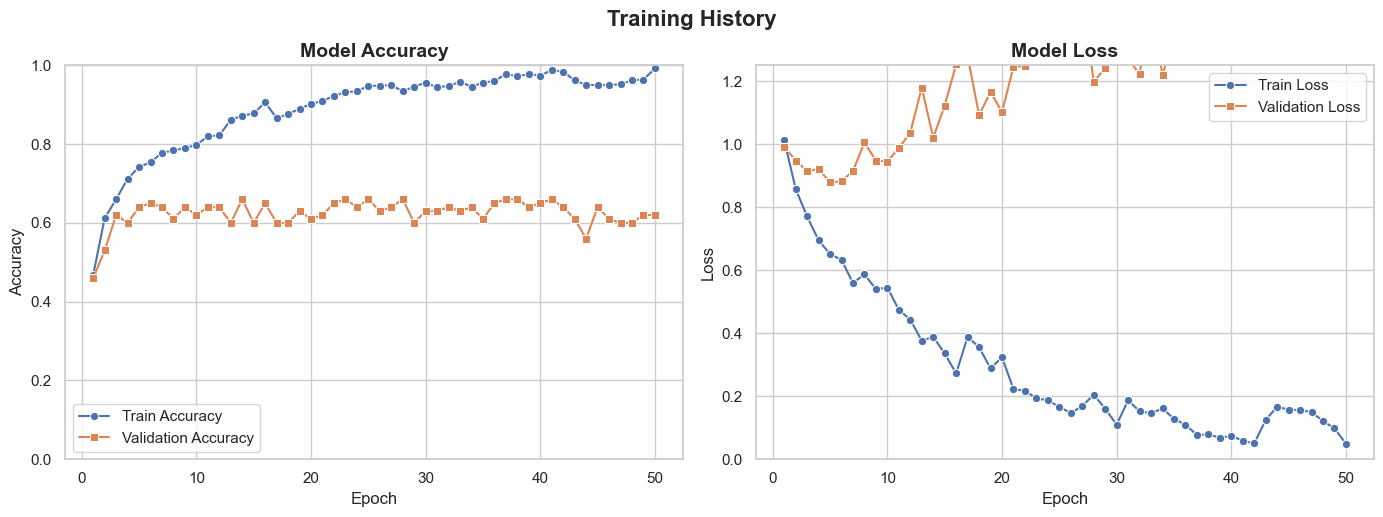

In [197]:
loss, accuracy = model_lstm_bidirectional.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_bidirectional.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_bidirectional.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_bidirectional.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_bi)

In [198]:
model_lstm_bidirectional.save(f'models/lstm_model_bidirectional.h5')

#### Compare

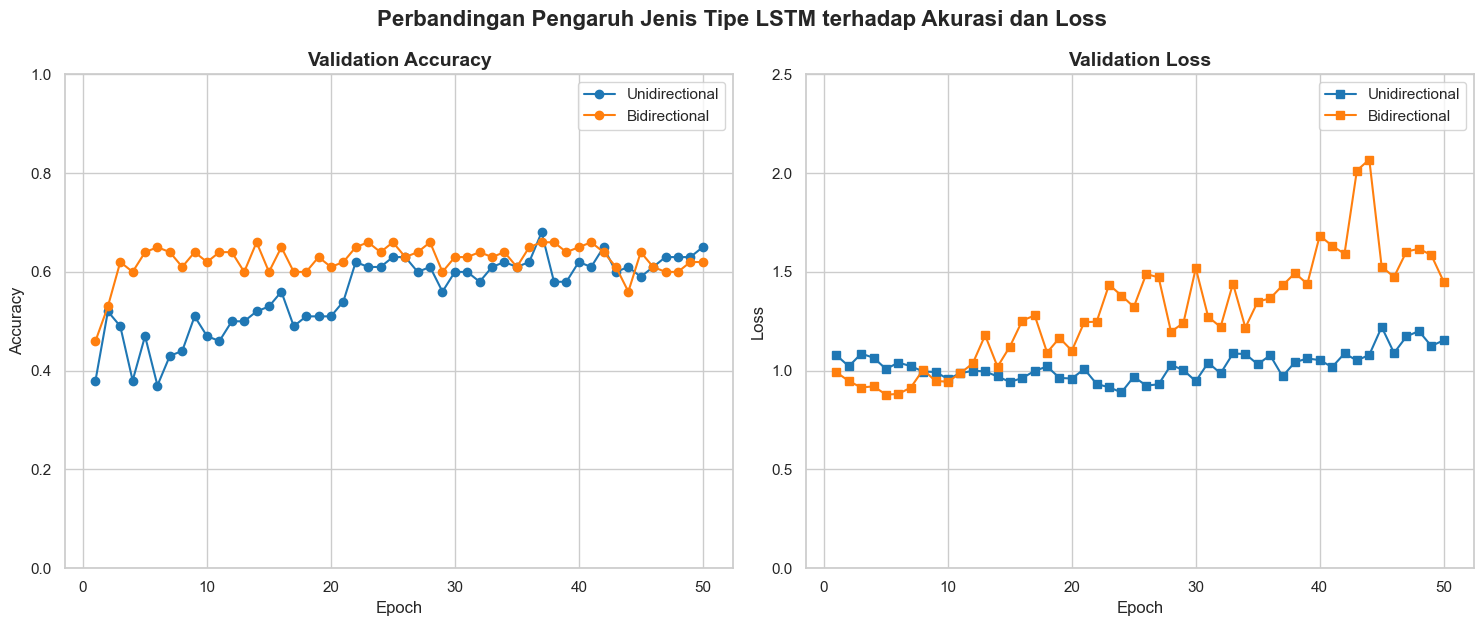

In [205]:
plot_multiple_training_histories(
    histories=[history_uni, history_bi],
    model_names=["Unidirectional", "Bidirectional"],
    title="Perbandingan Pengaruh Jenis Tipe LSTM terhadap Akurasi dan Loss"
)

## LSTM FROM SCRATCH

In [ ]:
batch_size = 100
seq_length = 20
vocab_size = 1000
num_classes = 3

lstm_model = LSTM_from_Scratch(
    embedding_dim=50,
    hidden_dim=64,
    num_classes=num_classes
)

history = lstm_model.fit(
    X_train, y_train,
    epochs=EPOCH,
    learning_rate=0.01,
    batch_size=16,
    verbose=True
)

lstm_model.summary()

Auto-detected vocabulary size: 2796
Training LSTM Model
Data shape: X_train (500, 100), y_train (500,)
Model parameters: vocab_size=2796, embedding_dim=50
                 hidden_dim=64, num_classes=3
Training parameters: epochs=50, lr=0.01, batch_size=16
Epoch   1/50 | Loss: 1.1042 | Train Acc: 0.2380
Epoch   3/50 | Loss: 1.1022
Epoch   5/50 | Loss: 1.1019
Epoch   6/50 | Loss: 1.1010 | Train Acc: 0.2380
Epoch   7/50 | Loss: 1.1006
Epoch   9/50 | Loss: 1.0994
Epoch  11/50 | Loss: 1.0984 | Train Acc: 0.3780
Epoch  13/50 | Loss: 1.0970
Epoch  15/50 | Loss: 1.0960
Epoch  16/50 | Loss: 1.0958 | Train Acc: 0.3780
Epoch  17/50 | Loss: 1.0952
Epoch  19/50 | Loss: 1.0943
Epoch  21/50 | Loss: 1.0940 | Train Acc: 0.3840
Epoch  23/50 | Loss: 1.0930
Epoch  25/50 | Loss: 1.0922
Epoch  26/50 | Loss: 1.0917 | Train Acc: 0.3780
Epoch  27/50 | Loss: 1.0913
Epoch  29/50 | Loss: 1.0911
Epoch  31/50 | Loss: 1.0899 | Train Acc: 0.3780
Epoch  33/50 | Loss: 1.0898
Epoch  35/50 | Loss: 1.0892
Epoch  36/50 | L

In [216]:
preds_train = lstm_model.predict(X_train)
preds_val = lstm_model.predict(X_val)
preds_test = lstm_model.predict(X_test)

print(f"Train F1 Score: {f1_score(y_train, preds_train, average='macro'):.4f}")
print(f"Validation F1 Score: {f1_score(y_val, preds_val, average='macro'):.4f}")
print(f"Test F1 Score: {f1_score(y_test, preds_test, average='macro'):.4f}")

print(f"\n" + "="*60)

Train F1 Score: 0.1829
Validation F1 Score: 0.1836
Test F1 Score: 0.1827



In [218]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score

vocab_size = 4000
embedding_dim = 50
hidden_dim = 64
num_classes = 3
max_len = 20

keras_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(hidden_dim, return_sequences=True),
    LSTM(hidden_dim, return_sequences=True),
    LSTM(hidden_dim, return_sequences=False),
    Dense(num_classes, activation='softmax')
])

keras_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

keras_history = keras_model.fit(
    X_train, y_train,
    epochs=EPOCH,
    batch_size=16,
    validation_data=(X_val, y_val) if 'X_val' in locals() else None,
    verbose=1
)

keras_preds_train = keras_model.predict(X_train)
keras_preds_train_label = keras_preds_train.argmax(axis=1)
keras_preds_val = keras_model.predict(X_val)
keras_preds_val_label = keras_preds_val.argmax(axis=1)
keras_preds_test = keras_model.predict(X_test)
keras_preds_test_label = keras_preds_test.argmax(axis=1)

keras_macro_f1_train = f1_score(y_train, keras_preds_train_label, average='macro')
print(f"Keras Model train Macro F1-score: {keras_macro_f1_train:.4f}")
keras_macro_f1_val = f1_score(y_val, keras_preds_val_label, average='macro')
print(f"Keras Model val Macro F1-score: {keras_macro_f1_val:.4f}")
keras_macro_f1_test = f1_score(y_test, keras_preds_test_label, average='macro')
print(f"Keras Model test Macro F1-score: {keras_macro_f1_test:.4f}")


Epoch 1/50


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.3162 - loss: 1.1186 - val_accuracy: 0.3800 - val_loss: 1.0866
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.3696 - loss: 1.0797 - val_accuracy: 0.3800 - val_loss: 1.0816
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.3765 - loss: 1.0771 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.3794 - loss: 1.0743 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.3519 - loss: 1.0723 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.3501 - loss: 1.0717 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.3501 - loss: 1.0714 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.3501 - loss: 1.0712 - val_accuracy: 0.3800 - val

In [226]:
def extract_lstm_weights(keras_lstm_layer):
    W, U, b = keras_lstm_layer.get_weights()
    # Keras order: i, f, c, o
    W_i, W_f, W_c, W_o = np.hsplit(W, 4)
    U_i, U_f, U_c, U_o = np.hsplit(U, 4)
    b_i, b_f, b_c, b_o = np.split(b, 4)
    return dict(
        Wf=W_f, Wi=W_i, Wc=W_c, Wo=W_o,
        Uf=U_f, Ui=U_i, Uc=U_c, Uo=U_o,
        bf=b_f, bi=b_i, bc=b_c, bo=b_o,
    )

embedding_weights = keras_model.layers[0].get_weights()[0]
embedding_dim = embedding_weights.shape[1]
hidden_dim = keras_model.layers[1].units
num_classes = keras_model.layers[-1].units

lstm1_w = extract_lstm_weights(keras_model.layers[1])
lstm2_w = extract_lstm_weights(keras_model.layers[2])
lstm3_w = extract_lstm_weights(keras_model.layers[3])
dense_W, dense_b = keras_model.layers[4].get_weights()

embedding_layer = EmbeddingLayer(embedding_weights)
lstm1 = LSTMLayer(input_dim=embedding_dim, hidden_dim=hidden_dim, return_sequences=True)
lstm2 = LSTMLayer(input_dim=hidden_dim, hidden_dim=hidden_dim, return_sequences=True)
lstm3 = LSTMLayer(input_dim=hidden_dim, hidden_dim=hidden_dim, return_sequences=False)
dense_layer = DenseLayer(input_dim=hidden_dim, output_dim=num_classes, activation='softmax')

for k in lstm1_w: setattr(lstm1, k, lstm1_w[k])
for k in lstm2_w: setattr(lstm2, k, lstm2_w[k])
for k in lstm3_w: setattr(lstm3, k, lstm3_w[k])
dense_layer.W = dense_W
dense_layer.b = dense_b

X_embed = embedding_layer.forward(X_val)  
h1 = lstm1.forward(X_embed)                  
h2 = lstm2.forward(h1)                       
h3 = lstm3.forward(h2)                       
output = dense_layer.forward(h3)      

predicted_labels = np.argmax(output, axis=1)

print("Feedforward Output (custom):")
print(predicted_labels)


Feedforward Output (custom):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [227]:
output_keras = keras_model.predict(X_val, verbose=0)
pred_labels_keras = np.argmax(output_keras, axis=1)

print(pred_labels_keras)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
from sklearn.metrics import classification_report

print("Scratch Model Classification Report (Validation):")
print(classification_report(y_val, preds_val, digits=4))

print("Keras Model Classification Report (Validation):")
print(classification_report(y_val, pred_labels_keras, digits=4))


Scratch Model Classification Report (Validation):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        38
           1     0.0000    0.0000    0.0000        24
           2     0.3800    1.0000    0.5507        38

    accuracy                         0.3800       100
   macro avg     0.1267    0.3333    0.1836       100
weighted avg     0.1444    0.3800    0.2093       100

Keras Model Classification Report (Validation):
              precision    recall  f1-score   support

           0     0.3800    1.0000    0.5507        38
           1     0.0000    0.0000    0.0000        24
           2     0.0000    0.0000    0.0000        38

    accuracy                         0.3800       100
   macro avg     0.1267    0.3333    0.1836       100
weighted avg     0.1444    0.3800    0.2093       100



c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif